# 控制释放试验 

In [1]:
import sys
import time
import numpy as np
import matplotlib.pyplot as plt

sys.path.append("C:\\Users\\RS\\VSCode\\matchedfiltermethod\\src")
from algorithms.matchedfilter import matched_filter as mf
from algorithms.columnwise_matchedfilter import columnwise_matched_filter as cmf
from algorithms.ml_matchedfilter import ml_matched_filter as mlmf
from algorithms.columnwise_ml_matchedfilter import columnwise_ml_matched_filter as cmlmf
from utils import satellites_data as sd
from utils import generate_radiance_lut_and_uas as glut


import math


# 基于IME算法进行排放量的估算
def emission_estimate(plume_array, pixel_resolution, windspeed_10m, slope, intercept, enhancement_unit='ppmm'):
    # calculate the area and the length of the plume
    nan_count = np.count_nonzero(~np.isnan(plume_array))
    pixel_area = math.pow(pixel_resolution, 2)
    plume_area = nan_count * pixel_area
    plume_length = math.sqrt(plume_area)
    # get the values of the plume
    plume_values = [value for value in plume_array.flatten() if value != -9999]
    if enhancement_unit == 'ppmm':
        # convert the unit from  ppm*m to kg/ppm*m, then calculate the integrated mass enhancement
        integrated_mass_enhancement = sum(plume_values) * 0.716 * 0.000001 * pixel_area
    elif enhancement_unit == 'ppm':
        # convert the unit from  ppm*m to kg/ppm by setting 8km as the scale of troposphere,
        # then calculate the integrated mass enhancement
        integrated_mass_enhancement = sum(plume_values) * 0.716 * 0.000001 * pixel_area * 8000
    else:
        print("The unit of the enhancement is not supported, please enter 'ppmm' or 'ppm'.")
    # calculate the effective windspeed with the formula
    effective_windspeed = slope * windspeed_10m + intercept
    # calculate the emission rate of the plume in the unit of kg/h
    emission_rate = (effective_windspeed * 3600 * integrated_mass_enhancement) / plume_length
    return emission_rate


# PRISMA 数据


## 影像浓度反演

first result: std-- 1771.6001112351917
Array 1 Stats:
Mean: 299.51, Std: 809.14, Min: 0.00, Max: 4387.20
Array 2 Stats:
Mean: 341.15, Std: 1052.78, Min: 0.00, Max: 7963.85


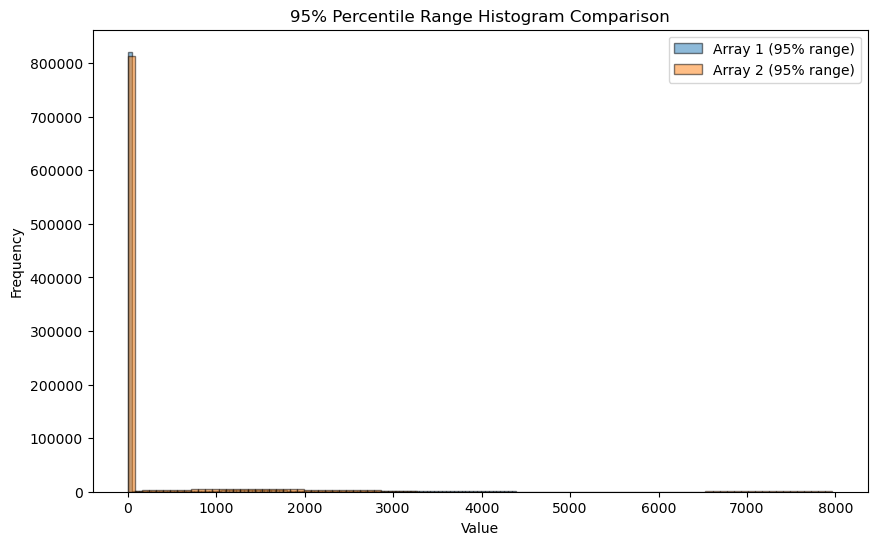

c:\Users\RS\.conda\envs\matchedfiltermethod\Lib\site-packages\rasterio\__init__.py:327: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = writer(


Time cost:  102.89289879798889


In [2]:
def PRISMA_test():
    filepath = "J:\stanford\PRISMA\PRS_L1_STD_OFFL_20221027182300_20221027182304_0001.he5"
    _,radiance_cube = sd.PRISMA_data.get_prisma_bands_array(filepath,2150,2500)
    sza,altitude = sd.PRISMA_data.get_prisma_SZA_altitude(filepath)
    if altitude > 5:
        altitude = 5
    _,uas = glut.generate_satellite_uas_for_specific_range_from_lut("PRISMA",0,50000,2150,2500,sza,altitude)


    # 原始匹配滤波算法结果测试
    mf_enhancement = mf(radiance_cube,uas,True,True,True)
    # cmf_enhancement = cmf(radiance_cube,uas,True,True,True,5)
    mlmf_enhancement = mlmf(radiance_cube,uas,"PRISMA",True,True,True)
    # 定义函数计算95%分位数内的直方图和统计信息
    def plot_histogram_and_stats(array, label):
        # 展开数组并计算95%分位数范围
        data = array.flatten()
        lower = np.percentile(data, 2.5)
        upper = np.percentile(data, 97.5)
        
        # 过滤出95%分位数范围内的数据
        filtered_data = data[(data >= lower) & (data <= upper)]
        
        # 绘制直方图
        plt.hist(filtered_data, bins=100, alpha=0.5, label=f'{label} (95% range)', edgecolor='black')
        
        # 计算统计信息
        mean = np.mean(filtered_data)
        std = np.std(filtered_data)
        print(f"{label} Stats:")
        print(f"Mean: {mean:.2f}, Std: {std:.2f}, Min: {filtered_data.min():.2f}, Max: {filtered_data.max():.2f}")
        
    # 绘制两个数组的直方图对比
    plt.figure(figsize=(10, 6))

    plot_histogram_and_stats(mf_enhancement, 'Array 1')
    plot_histogram_and_stats(mlmf_enhancement, 'Array 2')

    # 设置图例与标题
    plt.legend()
    plt.title('95% Percentile Range Histogram Comparison')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.show()
    # 多层匹配滤波算法结果测试

    output = "J:\stanford\PRISMA\PRS_L1_STD_OFFL_20221027182300_20221027182304_0001_mf.tif"
    sd.PRISMA_data.location_calibration(mf_enhancement,filepath,output)
    # output = "J:\stanford\PRISMA\PRS_L1_STD_OFFL_20221027182300_20221027182304_0001_cmf.tif"
    # sd.PRISMA_data.location_calibration(cmf_enhancement,filepath,output)
    output = "J:\stanford\PRISMA\PRS_L1_STD_OFFL_20221027182300_20221027182304_0001_mlmf.tif"
    sd.PRISMA_data.location_calibration(mlmf_enhancement,filepath,output)
    # return mf_enhancement,cmf_enhancement,mlmf_enhancement

start_time = time.time()
PRISMA_test()
finish_time = time.time()
print("Time cost: ",finish_time-start_time)

## 烟羽排放速率反演

In [ ]:
# 量化排放
plume_path = r"C:\Users\RS\Desktop\plumes\gf5_mf.tif"
plume_data = sd.general_functions.read_tiff_in_numpy(plume_path)
plume_data[plume_data == -3.4028231e+38] = np.nan
print(np.nanmax(plume_data))
fluxrate = emission_estimate(plume_data[plume_data >0],30,2.1274,1,0,"ppmm")
print(fluxrate/1000/8)

# AHSI 数据

## 影像浓度增强反演

In [ ]:
def AHSI_test():
    filepath = "J:\stanford\GF5B\GF5B_AHSI_W112.1_N32.8_20221115_006332_L10000239663_VNSW_Rad.dat"
    _,radiance_cube = sd.GF5B_data.get_AHSI_radiances_from_dat(filepath,2150,2500)
    sza,altitude = sd.GF5B_data.get_sza_altitude_from_dat(filepath)
    if altitude > 5:
        altitude = 5
    _,uas = glut.generate_satellite_uas_for_specific_range_from_lut("AHSI",0,50000,2150,2500,sza,altitude)

    # 原始匹配滤波算法结果测试
    mf_enhancement = mf(radiance_cube,uas, True, True,True)
    cmf_enhancement = cmf(radiance_cube,uas, True, True,True, 5)
    sd.general_functions.save_ndarray_to_tiff(mf_enhancement, "C:\\Users\\RS\\Desktop\\hi\\GF5B_mf.tif")
    sd.general_functions.save_ndarray_to_tiff(cmf_enhancement, "C:\\Users\\RS\\Desktop\\hi\\GF5B_cmf.tif")
    
    # np.save("methane_enhancement.npy",methane_enhancement)

    # # 打开原始影像文件
    # original_dataset = gdal.Open(filepath)

    # rpc_info = original_dataset.GetMetadata("RPC")

    # # 创建一个临时文件来存储结果数组
    # temp_file = tempfile.NamedTemporaryFile(suffix=".tif").name
    # driver = gdal.GetDriverByName("GTiff")
    # output_dataset = driver.Create(temp_file, result_array.shape[1], result_array.shape[0], 1, gdal.GDT_Float32)

    # # 将结果数组写入临时影像
    # output_band = output_dataset.GetRasterBand(1)
    # output_band.WriteArray(result_array)
    # output_band.FlushCache()

    # # 设置临时影像的地理信息
    # output_dataset.SetProjection(original_dataset.GetProjection())
    # output_dataset.SetGeoTransform(original_dataset.GetGeoTransform())

    # # 将RPC信息写入临时文件的元数据
    # output_dataset.SetMetadata(rpc_info, "RPC")

    # # 关闭并保存临时影像文件
    # output_dataset = None

    # # 使用 WarpOptions 并从临时文件路径进行校正
    # corrected_file = r"I:\stanford_campaign\Stanford_Campaign_GF5-02-AHSI\GF5B_AHSI_W112.1_N32.8_20221115_006332_L10000239663_VNSW_Rad_mlmf.tif"
    # warp_options = gdal.WarpOptions(rpc=True)
    # gdal.Warp(corrected_file, temp_file, options=warp_options)

    return mf_enhancement,cmf_enhancement

# 获取反演结果
mf_methane_enhancement,cmf_methane_enhancement = AHSI_test()



## 烟羽排放速率反演

In [ ]:

# 量化排放速率

plume_path = r"C:\Users\RS\Desktop\plumes\gf5_mf.tif"
plume_data = sd.general_functions.read_tiff_in_numpy(plume_path)
plume_data[plume_data == -3.4028231e+38] = np.nan
print(np.nanmax(plume_data))
fluxrate = emission_estimate(plume_data[plume_data >0],30,0.8656,1,0,"ppmm")
print(fluxrate/1000/8)


# EnMAP数据

In [ ]:
# ! 需要修改
def EnMAP_test():
    # filepath = r"I:\stanford_campaign\EnMAP\dims_op_oc_oc-en_701862725_1\ENMAP.HSI.L1B\ENMAP01-____L1B-DT0000005368_20221116T184050Z_005_V010501_20241017T040610Z\ENMAP01-____L1B-DT0000005368_20221116T184050Z_005_V010501_20241017T040610Z-SPECTRAL_IMAGE_SWIR.TIF"
    # filepath = r"I:\stanford_campaign\EnMAP\dims_op_oc_oc-en_701862725_1\ENMAP.HSI.L1B\ENMAP01-____L1B-DT0000005368_20221116T184050Z_005_V010501_20241017T042058Z\ENMAP01-____L1B-DT0000005368_20221116T184050Z_005_V010501_20241017T042058Z-SPECTRAL_IMAGE_SWIR.TIF"
    filepath = r"J:\stanford\EnMAP\ENMAP01-____L1B-DT0000005368_20221116T184046Z_004_V010501_20241017T040758Z\ENMAP01-____L1B-DT0000005368_20221116T184046Z_004_V010501_20241017T040758Z-SPECTRAL_IMAGE_SWIR.TIF"
    _,radiance_cube = sd.EnMAP_data.get_enmap_bands_array(filepath,2150,2500)
    sza = sd.EnMAP_data.get_center_sun_elevation(filepath.replace("SPECTRAL_IMAGE_SWIR.TIF", "METADATA.XML"))
    altitude = 0
    if altitude > 5:
        altitude = 5
    _,uas = glut.generate_satellite_uas_for_specific_range_from_lut("EnMAP",0,50000,2150,2500,sza,altitude)

    # 原始匹配滤波算法结果测试
    mf_enhancement = mf(radiance_cube,uas, True, True,True)
    cmf_enhancement = cmf(radiance_cube,uas, True, True,True,5)
    # 多层匹配滤波算法结果测试
    # methane_enhancement_mlmf = mfs.ml_matched_filter_new(radiance_cube,uas, True)
    
    # output_folder = os.path.dirname(filepath)
    # filename = os.path.basename(filepath)
    # vnir =  r"I:\stanford_campaign\EnMAP\dims_op_oc_oc-en_701862725_1\ENMAP.HSI.L1B\ENMAP01-____L1B-DT0000005368_20221116T184050Z_005_V010501_20241017T042058Z\ENMAP01-____L1B-DT0000005368_20221116T184050Z_005_V010501_20241017T042058Z-SPECTRAL_IMAGE_VNIR.TIF"
   
    # sd.EnMAP_data.export_enmap_array_to_tiff(mf_enhancement,filepath,output_folder,"cmf_" + filename)
    # sd.EnMAP_data.export_enmap_array_to_tiff(cmf_enhancement,filepath,output_folder,"cmf_" + filename)
    sd.general_functions.save_ndarray_to_tiff(mf_enhancement, "C:\\Users\\RS\\Desktop\\hi\\EnMAP_mf.tif")
    sd.general_functions.save_ndarray_to_tiff(cmf_enhancement, "C:\\Users\\RS\\Desktop\\hi\\EnMAP_cmf.tif")
    
    return mf_enhancement,cmf_enhancement

result = EnMAP_test()

In [ ]:
# 量化排放
plume_path = r"C:\Users\RS\Desktop\plumes\enmap_mf.tif"
plume_data = sd.general_functions.read_tiff_in_numpy(plume_path)
plume_data[plume_data == -3.4028231e+38] = np.nan
print(np.nanmax(plume_data))
fluxrate = emission_estimate(plume_data[plume_data >0],30,1,1,0,"ppmm")
print(fluxrate/8000)


# ZY1 数据

In [ ]:
def ZY1_test():
    filepath = r"J:\stanford\ZY1\ZY1F_AHSI_W111.72_N33.06_20221026_004370_L1A0000265656_VNSW_Rad.dat"
    # "I:\stanford_campaign\Stanford_Campaign_ZY1-02E-AHSI\ZY1F_AHSI_W111.74_N33.06_20221023_004327_L1A0000261518_VNSW_Rad.dat"
    # "I:\stanford_campaign\Stanford_Campaign_ZY1-02E-AHSI\ZY1F_AHSI_W111.85_N32.62_20221020_004284_L1A0000258234_VNSW_Rad.dat"
    _,radiance_cube = sd.ZY1_data.get_AHSI_radiances_from_dat(filepath,2150,2500)
    sza,altitude = sd.ZY1_data.get_sza_altitude(filepath)
    if altitude > 5:
        altitude = 5
    _,uas = glut.generate_satellite_uas_for_specific_range_from_lut("ZY1",0,50000,2150,2500,sza,altitude)

    # 原始匹配滤波算法结果测试
    mf_enhancement = mf(radiance_cube,uas, True, True,True)
    cmf_enhancement = cmf(radiance_cube,uas, True, True,True,5)
    # 多层匹配滤波算法结果测试
    # methane_enhancement_mlmf = mfs.ml_matched_filter_new(radiance_cube,uas, True)
    
    # np.save("methane_enhancement.npy",methane_enhancement)
    
    sd.general_functions.save_ndarray_to_tiff(mf_enhancement, "C:\\Users\\RS\\Desktop\\hi\\ZY1_mf.tif")
    sd.general_functions.save_ndarray_to_tiff(cmf_enhancement, "C:\\Users\\RS\\Desktop\\hi\\ZY1_cmf.tif")
    # 假设 result_array 是处理后的结果数组
    # result_array = methane_enhancement

    # # 打开原始影像文件
    # original_dataset = gdal.Open(filepath)

    # rpc_info = original_dataset.GetMetadata("RPC")

    # # 创建一个临时文件来存储结果数组
    # temp_file = tempfile.NamedTemporaryFile(suffix=".tif").name
    # driver = gdal.GetDriverByName("GTiff")
    # output_dataset = driver.Create(temp_file, result_array.shape[1], result_array.shape[0], 1, gdal.GDT_Float32)

    # # 将结果数组写入临时影像
    # output_band = output_dataset.GetRasterBand(1)
    # output_band.WriteArray(result_array)
    # output_band.FlushCache()

    # # 设置临时影像的地理信息
    # output_dataset.SetProjection(original_dataset.GetProjection())
    # output_dataset.SetGeoTransform(original_dataset.GetGeoTransform())

    # # 将RPC信息写入临时文件的元数据
    # output_dataset.SetMetadata(rpc_info, "RPC")

    # # 关闭并保存临时影像文件
    # output_dataset = None

    # # 使用 WarpOptions 并从临时文件路径进行校正
    # corrected_file = r"I:\stanford_campaign\Stanford_Campaign_ZY1-02E-AHSI\ZY1F_AHSI_W111.72_N33.06_20221026_004370_L1A0000265656_VNSW_Rad_mf.tif"
    # warp_options = gdal.WarpOptions(rpc=True)
    # gdal.Warp(corrected_file, temp_file, options=warp_options)
    return mf_enhancement,cmf_enhancement
mf_enhancement,cmf_enhancement = ZY1_test()



In [ ]:
# 量化排放
plume_path = r"C:\Users\RS\Desktop\plumes\zy1_mf.tif"
plume_data = sd.general_functions.read_tiff_in_numpy(plume_path)
print(np.nanmax(plume_data))
fluxrate = emission_estimate(plume_data[plume_data >0],30,2.3443,1,0,"ppmm")
print(fluxrate/8000)